# Assignment 3: Variational Autoencoders (VAEs)

## 1. Theory Questions

### Q1: Why is the KL Divergence term important in the VAE loss function?
Regularizing the latent space distribution is a critical function of the KL Divergence component in the VAE loss function. In order to preserve a coherent and significant latent space, it makes sure that the encoded latent vectors adhere to a typical normal distribution. This improves the model's ability to generalize by avoiding overfitting and promoting a continuous representation. Furthermore, by sampling from the learnt distribution, this regularization allows for smooth interpolation between points in the latent space, resulting in realistic data variations.


### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
In order to allow backpropagation across a VAE's stochastic layers, the reparameterization approach is necessary. It ensures that the gradients can be computed efficiently by separating the random sampling procedure from the network parameters. The method expresses random sampling as a deterministic function with extrinsic unpredictability, rather than sampling directly from the latent distribution. This makes the entire network end-to-end differentiable by allowing gradients to flow through the sampling process. Consequently, traditional gradient-based optimization approaches can be used to train the VAE effectively.


### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
To better capture the underlying structure of the data, a VAE employs a probabilistic latent space rather than a fixed latent space. Probability can be used to express data uncertainty, strengthening the model and increasing its ability to produce a variety of results. Additionally, this method guarantees that the latent space is meaningful and continuous, facilitating seamless transitions between various data points. Furthermore, by preventing overfitting to particular cases and allowing the model to produce fresh, realistic data, a probabilistic latent space improves generalization. Additionally, it facilitates better handling of input data changes, increasing the VAE's adaptability to various distributions.


### Q4: What role does KL Divergence play in ensuring a smooth latent space?
For a latent space in a VAE to be smooth and well-structured, KL Divergence is essential. It promotes the overlapping of the encoded representations rather than their isolation by preventing clusters from emerging in the latent space. By guaranteeing meaningful transitions between points, this overlap enables the model to produce seamless interpolations between various data samples. KL Divergence also guarantees that sampling from any location in the latent space yields consistent, realistic results, preserving consistency throughout the collected data.










## 2. Coding Questions


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
torch.manual_seed(42)


# 2.1 Task 1 Modfied VAE Architecture V/S VAE

# 🧠 ConvVAE: Convolutional Variational Autoencoder

## 📌 Overview
This is a **Convolutional Variational Autoencoder (ConvVAE)** implemented using PyTorch. It consists of:
- **Encoder**: Compresses input images into a latent space.
- **Latent Space**: Represents data in a lower-dimensional form.
- **Decoder**: Reconstructs the image from the latent vector.

## 🏗️ Model Architecture

## **1️⃣ Encoder**
- Takes an **image (3×32×32)** as input.
- Uses **Conv2D layers** to extract features.
- Outputs **mean (μ) and log variance (logvar)**.

## **2️⃣ Reparameterization Trick**
- Converts **(μ, logvar)** into a **latent vector (z)**.
- Ensures differentiability

## **3️⃣ Decoder**
- Takes **z** as input and reshapes it to (128×4×4).
- Uses **ConvTranspose2D layers** to upsample and reconstruct the image.

## 🔄 Forward Pass
1. **Encoder**: Extracts features → Outputs **μ, logvar**.
2. **Reparameterization**: Samples **z** from the latent space.
3. **Decoder**: Generates a reconstructed image from **z**.


In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Flatten()  # 128*4*4 = 2048
        )

        # Latent space
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3x32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 🔥 VAE Loss Function

The loss function in a Variational Autoencoder (VAE) consists of:

1️⃣ **Reconstruction Loss (BCE - Binary Cross Entropy)**  
2️⃣ **KL Divergence (KLD - Kullback-Leibler Divergence)**  


In [ ]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}] Loss: {loss.item():.4f}')
# Function to generate and display images
def generate_images(model, num_images=10, latent_dim=128):
    model.eval()
    with torch.no_grad():
        # Sample random points from latent space
        z = torch.randn(num_images, latent_dim).to(device)
        # Generate images
        sample = model.decode(z)

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*1.5, 1.5))
    for i, ax in enumerate(axes):
        img = sample[i].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 20
print(f"Training on device: {device}")

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)


print("Training completed!")

# Generate final sample of images
# generate_images(model, num_images=10)

Files already downloaded and verified
Training on device: cpu
Train Epoch: 1 [0/50000 (0%)]	Loss: 2129.9844
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1926.3627
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1895.0596
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1863.4868
====> Epoch: 1 Average loss: 1930.9944
Train Epoch: 2 [0/50000 (0%)]	Loss: 1890.7438
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1840.2559
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1844.6887
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1848.2050
====> Epoch: 2 Average loss: 1848.5532
Train Epoch: 3 [0/50000 (0%)]	Loss: 1849.2808
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1850.5564
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1847.8369
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1839.2607
====> Epoch: 3 Average loss: 1835.2028
Train Epoch: 4 [0/50000 (0%)]	Loss: 1845.0692
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1836.6863
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1844.4229
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1832.1311
====> Epoch: 4 Average lo

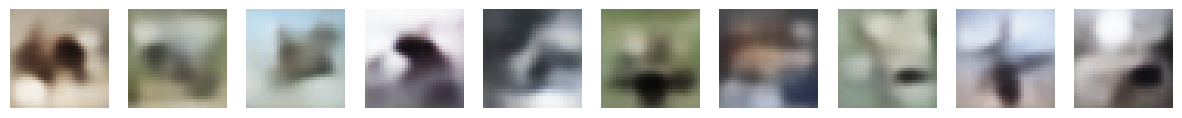

In [ ]:
generate_images(model, num_images=10)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define VAE for CIFAR-10
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 32x32x3 = 3072 for CIFAR-10

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))  # Output shape: (batch_size, 3072)

    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Flatten CIFAR-10 images
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function for CIFAR-10 VAE
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 3072), reduction='sum')  # Use MSE instead of BCE
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')



In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize for better training
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=3072, hidden_dim=512, latent_dim=128).to(device)  # Adjusted input and hidden sizes
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the VAE
for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)

Files already downloaded and verified
Epoch 1, Loss: 672.9125653125
Epoch 2, Loss: 603.5079028125
Epoch 3, Loss: 582.417771640625
Epoch 4, Loss: 570.260349375
Epoch 5, Loss: 563.218400546875
Epoch 6, Loss: 558.634886796875
Epoch 7, Loss: 555.6402290625
Epoch 8, Loss: 553.720868359375
Epoch 9, Loss: 552.102713359375
Epoch 10, Loss: 550.936365


In [10]:

def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space
        z = torch.randn(num_images, latent_dim).to(device)  # Ensure it's on the right device
        # Decode to generate images
        generated_images = model.decode(z).cpu().numpy()  # Convert to NumPy array

    # Reshape the images (batch_size, 3, 32, 32)
    generated_images = generated_images.reshape(num_images, 3, 32, 32)

    # Normalize images to [0,1] for display
    generated_images = (generated_images - generated_images.min()) / (generated_images.max() - generated_images.min())

    # Plot generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        axs[i].axis('off')
    plt.show()

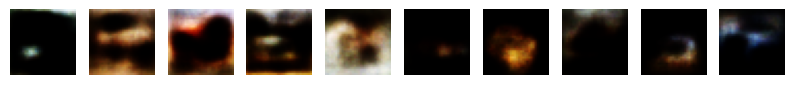

In [11]:
generate_images(vae, num_images=10, latent_dim=128)


We can see the clear difference between the image generated with VAE vs ConVAE above

# 2.2 Task 2 Interpoltion between images


In [ ]:
def get_latent_vector(model, image):
    """Get the latent vector for a given image"""
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        mu, logvar = model.encode(image)
        z = model.reparameterize(mu, logvar)
    return z

def interpolate_latent_vectors(z1, z2, steps=10):
    """Create interpolated points between two latent vectors"""
    interpolated = []
    for alpha in torch.linspace(0, 1, steps):
        interpolated.append(z1 * (1 - alpha) + z2 * alpha)
    return torch.stack(interpolated)

def visualize_interpolation(model, img1, img2, steps=10):
    """Visualize interpolation between two images"""
    model.eval()

    # Get latent vectors for both images
    z1 = get_latent_vector(model, img1)
    z2 = get_latent_vector(model, img2)

    # Generate interpolated images
    interpolated_z = interpolate_latent_vectors(z1, z2, steps)

    with torch.no_grad():
        interpolated_images = model.decode(interpolated_z)

    # Plot original images and interpolation
    plt.figure(figsize=(15, 3))

    # Plot all images including original and interpolated
    all_images = torch.cat([img1.unsqueeze(0).to(device),
                          interpolated_images,
                          img2.unsqueeze(0).to(device)])

    fig, axes = plt.subplots(1, steps + 2, figsize=((steps + 2) * 1.5, 1.5))
    for i, ax in enumerate(axes):
        img = all_images[i].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
        if i == 0:
            ax.set_title('Source')
        elif i == steps + 1:
            ax.set_title('Target')
        else:
            ax.set_title(f'{i/(steps+1):.1f}')

    plt.tight_layout()
    plt.show()

def interpolate_between_classes(model, train_loader, class1, class2, steps=10):
    """Interpolate between two specific classes from CIFAR-10"""
    # Get one image from each class
    img1, img2 = None, None

    for images, labels in train_loader:
        mask1 = labels == class1
        mask2 = labels == class2
        if img1 is None and mask1.any():
            img1 = images[mask1][0]
        if img2 is None and mask2.any():
            img2 = images[mask2][0]
        if img1 is not None and img2 is not None:
            break

    visualize_interpolation(model, img1, img2, steps)


Interpolating between different classes...

Interpolating between airplane and automobile:


<Figure size 1500x300 with 0 Axes>

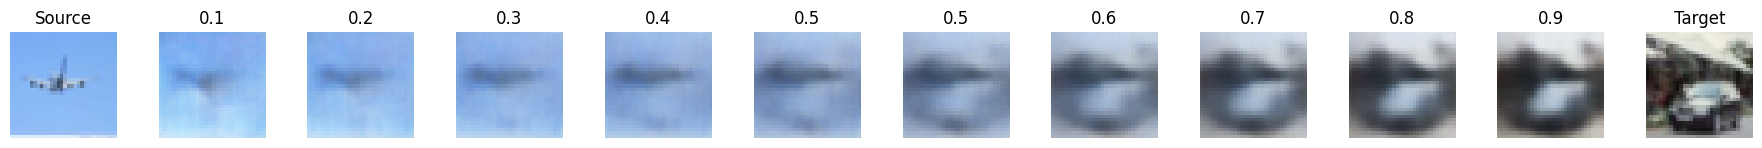

In [ ]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Example usage:
print("Interpolating between different classes...")

# Interpolate between airplane (0) and automobile (1)
print("\nInterpolating between airplane and automobile:")
interpolate_between_classes(model, train_loader, 0, 1)




Interpolating between bird and cat:


<Figure size 1500x300 with 0 Axes>

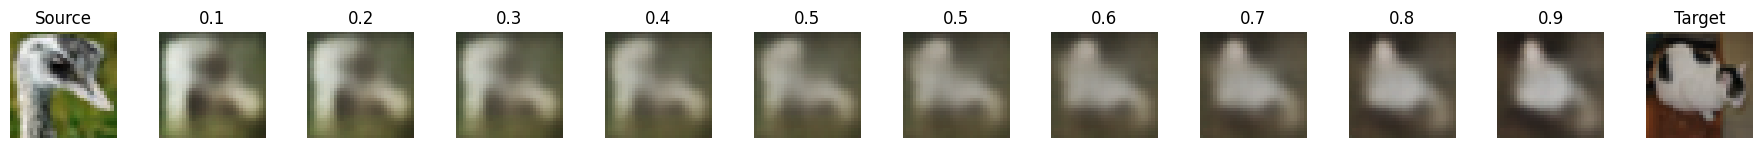

In [ ]:
# Interpolate between bird (2) and cat (3)
print("\nInterpolating between bird and cat:")
interpolate_between_classes(model, train_loader, 2, 3)




Interpolating between cat and dog:


<Figure size 1500x300 with 0 Axes>

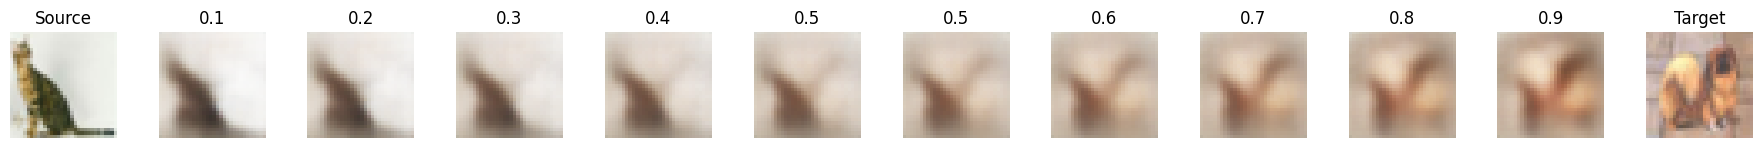

In [ ]:
# Interpolate between cat (3) and dog (5)
print("\nInterpolating between cat and dog:")
interpolate_between_classes(model, train_loader, 3, 5)

# Task 3: Training VAE on Flowers102 Dataset

## Dataset Overview
- 8,189 images across 102 different flower categories
- High-quality color images
- Varied angles and lighting conditions
- Common flowers found in the UK

## Why Flowers102?
- Natural color variations and patterns
- Good for testing VAE's ability to learn and generate:
 - Color patterns
 - Petal shapes
 - Natural textures
- Simpler dataset compared to faces (CelebA) but still challenging


Training on device: cpu
Epoch: 1 [0/1020 (0%)]	Loss: 9204.1514
====> Epoch: 1 Average loss: 8869.7380
Epoch: 2 [0/1020 (0%)]	Loss: 8549.4902
====> Epoch: 2 Average loss: 8412.6080
Epoch: 3 [0/1020 (0%)]	Loss: 8281.8408
====> Epoch: 3 Average loss: 8142.4579
Epoch: 4 [0/1020 (0%)]	Loss: 7996.9263
====> Epoch: 4 Average loss: 7869.7778
Epoch: 5 [0/1020 (0%)]	Loss: 7802.0078
====> Epoch: 5 Average loss: 7680.6123
Epoch: 6 [0/1020 (0%)]	Loss: 7664.0298
====> Epoch: 6 Average loss: 7536.0206
Epoch: 7 [0/1020 (0%)]	Loss: 7439.5732
====> Epoch: 7 Average loss: 7425.5835
Epoch: 8 [0/1020 (0%)]	Loss: 7451.6191
====> Epoch: 8 Average loss: 7338.8218
Epoch: 9 [0/1020 (0%)]	Loss: 7414.1162
====> Epoch: 9 Average loss: 7260.2736
Epoch: 10 [0/1020 (0%)]	Loss: 7137.7686
====> Epoch: 10 Average loss: 7200.5350
Epoch: 11 [0/1020 (0%)]	Loss: 6935.7725
====> Epoch: 11 Average loss: 7151.8165
Epoch: 12 [0/1020 (0%)]	Loss: 7133.1582
====> Epoch: 12 Average loss: 7109.2304
Epoch: 13 [0/1020 (0%)]	Loss: 6951

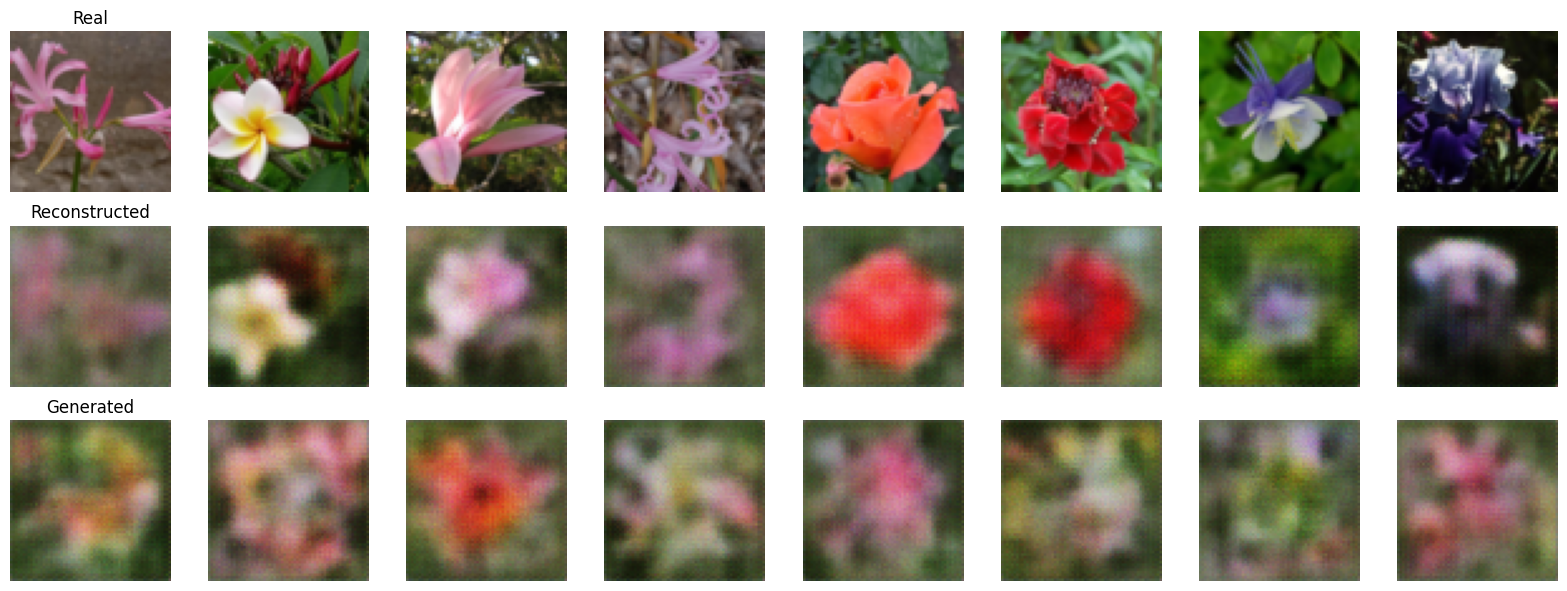

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# Set random seed for reproducibility
torch.manual_seed(42)
class FlowerVAE(nn.Module):
    def __init__(self, latent_dim):
        super(FlowerVAE, self).__init__()

        # Encoder - more layers for higher resolution
        self.encoder = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten()  # 256 * 4 * 4
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 3 x 64 x 64
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 256, 4, 4)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function with KL weight scheduling
def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD

# Training function
def train_epoch(model, train_loader, optimizer, epoch, kl_weight):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, kl_weight)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.4f}')

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

# Function to visualize results
def visualize_results(model, data_loader, num_images=8):
    model.eval()

    # Get a batch of real images
    real_batch = next(iter(data_loader))[0][:num_images].to(device)

    # Generate reconstructions
    with torch.no_grad():
        recon_batch, _, _ = model(real_batch)

        # Generate random samples
        sample = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(sample)

    # Plot results
    fig, axes = plt.subplots(3, num_images, figsize=(2*num_images, 6))

    for i in range(num_images):
        # Plot real images
        axes[0, i].imshow(real_batch[i].cpu().permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Real')

        # Plot reconstructions
        axes[1, i].imshow(recon_batch[i].cpu().permute(1, 2, 0))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')

        # Plot generated images
        axes[2, i].imshow(generated[i].cpu().permute(1, 2, 0))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Generated')

    plt.tight_layout()
    plt.show()

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

# Load Flowers102 dataset
dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256  # Increased latent dimension for more complex images
model = FlowerVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
print(f"Training on device: {device}")

# KL annealing
kl_weight = 0.0
kl_step = 1.0 / (num_epochs // 2)  # Gradually increase to 1.0 over half the epochs

for epoch in range(1, num_epochs + 1):
    # Update KL weight
    if epoch <= num_epochs // 2:
        kl_weight = min(1.0, kl_weight + kl_step)

    # Train for one epoch
    loss = train_epoch(model, train_loader, optimizer, epoch, kl_weight)

    # Visualize results periodically
    # if epoch % 10 == 0:
    #     print(f"\nResults after epoch {epoch}:")
    #     visualize_results(model, train_loader)

    # Save checkpoint
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'flower_vae_checkpoint_epoch_{epoch}.pth')

print("Training completed!")

# Generate final results
print("\nFinal results:")
visualize_results(model, train_loader, num_images=8)

# Function to explore latent space
def explore_latent_space(model, num_variations=5):
    """Generate variations by sampling different regions of the latent space"""
    model.eval()
    with torch.no_grad():
        # Sample points from different regions of the latent space
        z_samples = []
        # Standard normal distribution
        z_samples.append(torch.randn(num_variations, latent_dim).to(device))
        # More concentrated around the origin
        z_samples.append(torch.randn(num_variations, latent_dim).to(device) * 0.5)
        # More spread out
        z_samples.append(torch.randn(num_variations, latent_dim).to(device) * 2.0)

        # Generate images
        fig, axes = plt.subplots(len(z_samples), num_variations,
                                figsize=(2*num_variations, 2*len(z_samples)))

        for i, z in enumerate(z_samples):
            generated = model.decode(z)
            for j in range(num_variations):
                axes[i, j].imshow(generated[j].cpu().permute(1, 2, 0))
                axes[i, j].axis('off')

            if i == 0:
                axes[i, 0].set_title('Standard\nsampling', loc='left')
            elif i == 1:
                axes[i, 0].set_title('Concentrated\nsampling', loc='left')
            else:
                axes[i, 0].set_title('Spread out\nsampling', loc='left')

        plt.tight_layout()
        plt.show()



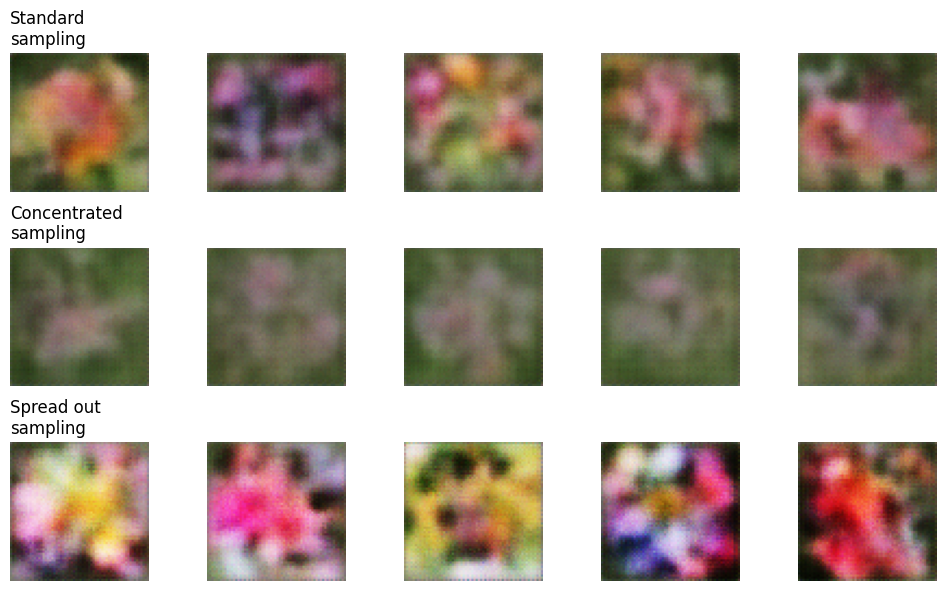

In [ ]:
explore_latent_space(model)
